<a id="top"></a>
# Object Detection Sample Application

## Prerequisites
This sample requires the following:
- All files are present and in the following directory structure:
    - **object_detection.ipynb** - This Jupyter* Notebook
    - **object_detection.py** - Python* code for object detection application
    - **object_detection_annotate.py** - Python* code to perform post-processing to annotate output video
    - **labels.txt** - Mapping of numerical labels to text strings
    - **/data/reference-sample-data/object-detection-python/cars_1900.mp4** - Test video

It is recommended that you have already read the following from [Get Started on the Intel® DevCloud for the Edge](https://devcloud.intel.com/edge/home/):
- [Overview of the Intel® DevCloud for the Edge](https://devcloud.intel.com/edge/get_started/devcloud/)
- [Overview of the Intel® Distribution of OpenVINO™ toolkit](https://devcloud.intel.com/edge/get_started/openvino/)

<br><div class=note><i><b>Note: </b>It is assumed that the server this sample is being run on is on the Intel® DevCloud for the Edge which has Jupyter* Notebook customizations and all the required libraries already installed.  If you download or copy to a new server, this sample may not run.</i></div>


## Introduction

This sample application demonstrates how a smart video IoT solution may be created using Intel® hardware and software tools to perform object detection.  This solution detects any number of objects within a video frame looking specifically for known objects. 

The results for each frame are stored in a text file that is later read by a second pass to annotate the input video with boxes around detected objects with a label and probability value.

### Key concepts
This sample application includes an example for the following:
- Application:
  - Video and image input is supported using OpenCV
  - OpenCV is used to draw bounding boxes around detected objects, labels, and other information
  - Visualization of the resulting bounding boxes in the output
  - Uses the [Async API](https://docs.openvinotoolkit.org/latest/_docs_IE_DG_Intro_to_Performance.html) feature of the Inference Engine
- Intel® DevCloud for the Edge:
  - Submitting inference as jobs that are performed on different edge compute nodes (rather than on the development node hosting this Jupyter* notebook)
  - Monitoring job status
  - Viewing results and assessing performance for hardware on different compute nodes
- [Intel® Distribution of OpenVINO™ toolkit](https://software.intel.com/openvino-toolkit):
  - Create the necessary Intermediate Representation (IR) files for the inference model using the [Model Downloader](http://docs.openvinotoolkit.org/latest/_tools_downloader_README.html) and [Model Optimizer](http://docs.openvinotoolkit.org/latest/_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html)
  - Run an inference application on multiple hardware devices using the [Inference Engine](http://docs.openvinotoolkit.org/latest/_docs_IE_DG_Deep_Learning_Inference_Engine_DevGuide.html)


### Async API feature

Inference may be run in the Inference Engine using either the synchronous (blocking) or asynchronous (non-blocking) API of the [ExectuableNetwork](https://docs.openvinotoolkit.org/latest/ie_python_api/classie__api_1_1ExecutableNetwork.html) and [InferRequest](https://docs.openvinotoolkit.org/latest/ie_python_api/classie__api_1_1InferRequest.html) classes:
- Synchronous API:
```python
   # Runs inference and returns results when complete
   result = exec_net.infer(inputs) 
```

- Asynchronous API
```python
   # Start inference and return immediately with an InferenceRequest (optional to use)
   infer_request = exec_net.start_async(request_id, inputs)

   # ... Perform other work such as capturing input data, preprocessing input data,
   #     post-processing results, etc. ...

   # Check the status of inference one of two ways, both use timeout set to:
   #    ms_timeout = 0      - Return status immediately whether inference is complete or not
   #    ms_timeout = -1     - Wait until inference is complete, then return
   #    ms_timeout = <time> - Wait time in milliseconds or until inference complete

   # Option #1: Use the returned InferenceRequest
   infer_status = infer_request.wait(ms_timeout)

   # Option #2: Lookup InferenceRequest using the request_id used with start_async()
   infer_status = exec_net.requests[my_request_id].wait(ms_timeout)
```

<br><div class=note><i><b>Note: </b>Using `infer()` is effectively the same as calling `start_async()` immediately followed by waiting for the results.</i></div>

The [Async API](https://docs.openvinotoolkit.org/latest/_docs_IE_DG_Intro_to_Performance.html) feature is used to run inference in parallel on either a separate thread or device allowing the main thread to continue to do other work such as capturing input data, preprocessing input data, post-processing results, etc.  In this sample application, the Async API is used to perform inference in parallel with loading the next video frame and post-processing inference results. 
Below is an outline of the code for the main loop appearing in [object_detection.py](./object_detection.py):

```python
current_inference = 0
previous_inference = 1 - args.number_infer_requests
infer_requests = exec_net.requests
frame_count = 0

while frame_count < video_len:
    # Read next frame from input stream if available and submit it for inference 
    # ...
        exec_net.start_async(request_id=current_inference, inputs={input_blob: in_frame})

    # Retrieve the output of an earlier inference request
    if previous_inference >= 0:
        status = infer_requests[previous_inference].wait()
        # ... post-processing current frame ...
        frame_count += 1

    # Increment counter for the inference queue and roll them over if necessary 
    current_inference += 1
    if current_inference >= args.number_infer_requests:
        current_inference = 0

    previous_inference += 1
    if previous_inference >= args.number_infer_requests:
        previous_inference = 0
```

## Object detection application
The object detection application uses the Intel® Distribution of OpenVINO™ toolkit to perform inference on an input video to locate known objects within each frame.  We will setup, run, and view the results for this application for several different hardware devices (CPU. GPU, etc.) available on the compute nodes within the Intel® DevCloud for the Edge.  To accomplish this, we will be performing the following tasks:

1. Use the [Model Downloader](http://docs.openvinotoolkit.org/latest/_tools_downloader_README.html) to download the inference model IR files needed to perform inference
2. Use the [Model Optimizer](http://docs.openvinotoolkit.org/latest/_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html) to create the model IR files in the necessary precisions
3. Create the job file used to submit running inference on compute nodes
4. Submit jobs for different compute nodes and monitor the job status until complete
5. View results and assess performance 

### How it works
At startup the object detection application configures itself by parsing the command line arguments and reading the specified labels file.  Once configured, the application loads the specified inference model's IR files into the [Inference Engine](http://docs.openvinotoolkit.org/latest/_docs_IE_DG_Deep_Learning_Inference_Engine_DevGuide.html) and runs the three phases described in the following sections.
#### Phase 1:  Pre-processing
The frames from the specified input video are read and pre-processed to have the frame data ready for input into inference.  Each frame is resized and its channels are transposed to match the input of the input requirements of the inference model.  The resulting blocks of frame data are written to the binary file `tmp/processed_vid.bin`.

#### Phase 2:  Inference
The binary file `tmp/processed_vid.bin` is read for input to inference to detect known objects.  For each detected object within a frame, a message is written as a line to the output text file in the form:
```
   <frame_id> <xmin> <ymin> <xmax> <ymax> <class_id> <det_label> <det_time>
```
Where each field reports:
- <*frame_id*> - Frame number of results
- <*xmin*> - Minimum x coordinate for restriction zone
- <*ymin*> - Minimum y coordinate for restriction zone
- <*xmax*> - Maximum x coordinate for restriction zone
- <*ymax*> - Maximum y coordinate for restriction zone
- <*class_id*> - The class identifier (integer) from the inference results 
- <*det_label*> - Detection label: "True" if safe, "False" if unsafe
- <*det_time*> - Detection time taken to perform inference ("N/A" due to using Async API)

#### Phase 3:  Post-processing
After the object detection application has finished running inference, a second executable is run to annotate the input video with the results from the output text file.  The final results is an output video with boxes drawn around detected objects with each box appearing with a label and probability value.

In this sample, we provide three performance numbers for each architecture. However, they are not hard limits on the solution's performance. It is important to understand that for any application, you may want to combine preprocessing, inference, and post-processing, as opposed to separating them as done here. Combined preprocessing has several advantages:
- If inference is run asynchronously on the accelerator, the rest of the system is available for parallel tasks for capturing input, preprocessing future frames, or post-processing past frames.
- The inference application pipeline has better data locality, allowing for the reuse of data in caches such as in the application's memory or in the hard drive's cache. 

To run the application on the Intel® DevCloud for the Edge, a job is submitted to an edge compute node with a hardware accelerator such as Intel® HD Graphics GPU and Intel® Movidius™ Neural Compute Stick 2.  After inference on the input is completed, the output is stored in the appropriate `results/<architecture>/` directory.  The results are then viewed within this Jupyter* Notebook using the `videoHTML` video playback utility.

The application and inference code for this sample is already implemented in the Python* files: 
- First pass, detection using inference: [`object_detection.py`](./object_detection.py)
- Second pass, annotation using detection results: [`object_detection_annotate.py`](./object_detection_annotate.py)

The following sections will guide you through configuring and running the object detection application.

### Configuration
The following sections describe all the necessary configuration to run the object detection application.
#### Command line arguments
The application is run from the command line using the following format:
```bash
python3 object_detection.py <arguments...>
```
The required command line _<arguments...>_ to run the Python* executable [`object_detection.py`](./object_detection.py) are:
- **-m** - Path to the _.xml_ IR file (created using [Model Optimizer](http://docs.openvinotoolkit.org/latest/_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html)) for the inference model. 
- **-i** - Path to input video file
- **--labels** - Path to labels file that matches the trained model used
- **-o** - The path to where the output video file will be stored
- **-d** - Device type to use to run inference (CPU, GPU, MYRIAD)
- **-nreq** - The maximum number of requests to allow while using the Async API

The second pass of the application to annotate video with results is run from the command line using the following format:
```bash
python3 object_detection_annotate.py <arguments...>
```
The required command line _<arguments...>_ to run the application Python* executable [`object_detection_annotate.py`](./object_detection_annotate.py) are:
- **-i** - Path to input video file
- **-o** - The path to where the output video file will be stored.  Also used with environment variable `PBS_JOBID` to find output text file from application executable
- **-f** - Output frame rate scale value (FPS=50.0/<*val*>)
- **-s** - Output resolution scale value to (input_w*<*val*>,input_h*<*val*>) 

#### The labels file

In order to label detected objects, the sample application requires a labels file associated with the model being used for detection.  The labels file is a text file containing all the classes/labels that the model can recognize, in the order that it was trained to recognize them (one class per line).  The included labels file `labels.txt`, is intended to be used with the specific `mobilenet-ssd` model that will be used for inference.

Below are the contents of the `labels.txt` file that we will be using:
```
background
aeroplane
bicycle
bird
boat
bottle
bus
car
cat
chair
cow
diningtable
dog
horse
motorbike
person
pottedplant
sheep
sofa
train
tvmonitor
```

### Imports
We begin by importing all the Python* modules that will be used within this Jupyter* Notebook to run and display the results of the object detection application on the Intel® DevCloud for the Edge:
- [os](https://docs.python.org/3/library/os.html#module-os) - Operating system specific module (used for file name parsing)
- [time](https://docs.python.org/3/library/time.html#module-time) - Time tracking module (used for measuring execution time)
- [matplotlib.pyplot](https://matplotlib.org/) - pyplot is used for displaying output images
- [sys](https://docs.python.org/3/library/sys.html#module-sys) - System specific parameters and functions
- [qarpo.demoutils](https://github.com/ColfaxResearch/qarpo) - Provides utilities for displaying results and managing jobs from within this Jupyter* Notebook

Run the following cell to import the Python* dependencies needed.

<br><div class=tip><b>Tip: </b>Select a cell and then use **Ctrl+Enter** to run that cell.</div>

In [1]:
import matplotlib.pyplot as plt
import os
import time
import sys
from qarpo.demoutils import *
from qarpo.model_visualizer_link import *
print('Imported Python modules successfully.')
!echo $VENV_PATH

Imported Python modules successfully.
/data/venv/openvino_2022.1.0.643


### Create the IR files for the inference model

The Intel® Distribution of OpenVINO™ toolkit includes the [Model Optimizer](http://docs.openvinotoolkit.org/latest/_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html) used to convert and optimize trained models into the Intermediate Representation (IR) model files, and the [Inference Engine](http://docs.openvinotoolkit.org/latest/_docs_IE_DG_Deep_Learning_Inference_Engine_DevGuide.html) that uses the IR model files to run inference on hardware devices.  The IR model files can be created from trained models from popular frameworks (e.g. Caffe\*, Tensorflow*, etc.). 
The Intel® Distribution of OpenVINO™ toolkit also includes the [Model Downloader](http://docs.openvinotoolkit.org/latest/_tools_downloader_README.html) utility  to download some common inference models from the [Open Model Zoo](https://github.com/opencv/open_model_zoo). 

Run the following cell to run the Model Downloader utility with the `--print_all` argument to see all the available inference models.

In [2]:
!omz_downloader --print_all

Sphereface
aclnet
aclnet-int8
action-recognition-0001
age-gender-recognition-retail-0013
alexnet
anti-spoof-mn3
asl-recognition-0004
background-matting-mobilenetv2
bert-base-ner
bert-large-uncased-whole-word-masking-squad-0001
bert-large-uncased-whole-word-masking-squad-emb-0001
bert-large-uncased-whole-word-masking-squad-int8-0001
bert-small-uncased-whole-word-masking-squad-0001
bert-small-uncased-whole-word-masking-squad-0002
bert-small-uncased-whole-word-masking-squad-emb-int8-0001
bert-small-uncased-whole-word-masking-squad-int8-0002
brain-tumor-segmentation-0001
brain-tumor-segmentation-0002
caffenet
cocosnet
colorization-siggraph
colorization-v2
common-sign-language-0001
common-sign-language-0002
ctdet_coco_dlav0_512
ctpn
deblurgan-v2
deeplabv3
densenet-121
densenet-121-tf
detr-resnet50
dla-34
driver-action-recognition-adas-0002
drn-d-38
efficientdet-d0-tf
efficientdet-d1-tf
efficientnet-b0
efficientnet-b0-pytorch
efficientnet-v2-b0
efficientnet-v2-s
emotions-recognition-retail-0

<br><div class=tip><i><b>Tip: </b>The '!' at the beginning is a special Jupyter* Notebook command that allows you to run shell commands as if you are at a command line. The above command will also work in a terminal (with the '!' removed).</i></div>

Some of these downloaded models are already in the IR format, while others will require the Model Optimizer to be run. For our application, we will be using the [`mobilenet-ssd`](https://github.com/opencv/open_model_zoo/tree/master/models/public/mobilenet-ssd) inference model, which will require being optimization using the Model Optimizer to create the model in the necessary IR format neede by the Inference Engine to run. 

The format for the Model Downloader command to download a model is:
```bash
/opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py \
    --name <model_name> -o <output_directory>
```
The input arguments are as follows:
- **--name** : The name of the model you want to download. It should be one of the models listed in the previous cell.
- **-o** : The output directory where to store the downloaded model. If the directory does not exist, it will be created.

Run the following cell to download the `mobilenet-ssd` model to the `./raw_models` directory relative to the location of this Jupyter* Notebook.

In [3]:
#!downloader.py --name mobilenet-ssd -o raw_models
!mkdir -p raw_models/public
!cp -r  /data/reference-sample-data/raw_models/mobilenet-ssd raw_models/public
!echo "\nAll files that were downloaded:"
!find ./raw_models

\nAll files that were downloaded:
./raw_models
./raw_models/public
./raw_models/public/mobilenet-ssd
./raw_models/public/mobilenet-ssd/mobilenet-ssd.prototxt
./raw_models/public/mobilenet-ssd/mobilenet-ssd.caffemodel


To view a graph of the model used in this application, run the cell below then select the link generated:

In [4]:
showModelVisualizerLink("raw_models/public/mobilenet-ssd/mobilenet-ssd.caffemodel")

HTML(value='View model graph:  <span title="View model">&#128065; </span><a target=\'_blank\' href=\'/services…

As shown above from the output of the last `!find...` command, the necessary model files created using the Caffe* framework have been downloaded:
- **mobilenet-ssd.prototxt** - The deployed [Protocol Buffer](https://developers.google.com/protocol-buffers) file that describes the network architecture to run inference
- **mobilenet-ssd.caffemodel** - Binary containing trained weights

These files will need to be optimized using the Model Optimizer to create the necessary IR files.  We will be running the inference model on different hardware devices which have different requirements on the precision of the model (see [Inference Engine Supported Model Formats](https://docs.openvinotoolkit.org/latest/_docs_IE_DG_supported_plugins_Supported_Devices.html#supported_model_formats) for details).  For our purposes, we will focus on the use of the two most common precisions, FP32 and FP16.

For this model, we will run the Model Optimizer using the format:
```bash
mo \
    --input_model <path_to_caffemodel> \
    --data_type <data_precision> \
    --output_dir <path_to_output_directory> \
    --scale <scale_value> \
    --mean_values [<channel_mean_values>] 
```

The input arguments are as follows:
- **--input_model** : The model's input *.caffemodel* file  (the *.prototxt* with the same base name will be automatically found, otherwise the `--input_proto` argument would need to be specified)
- **--data_type** : The model's data type and precision (e.g. FP16, FP32, INT8, etc.)
- **--output_dir** : Output directory where to store the generated IR model files
- **--scale** : Scaling (divide by) value to apply to input values
- **--mean_values** : Mean values (one per channel) to be subtracted from input values before scaling


For converting our model, we will use the typical scaling value `256` and mean values `[127,127,127]` used with Caffe* models.  The complete command will look like the following:
```bash
!mo \
    --input_model raw_models/public/mobilenet-ssd/mobilenet-ssd.caffemodel \
    --data_type <data_precision> \
    --output_dir models/mobilenet-ssd/<data_precision> \
    --scale 256 \
    --mean_values [127,127,127] 
```
We will run the command twice, first with <*data_precision*> set to `FP16` and then `FP32` to get all the IR files we will need to run inference on different devices.

<br><div class=note><i><b>Note: </b>More information on how to use Model Optimizer to convert Caffe* models may be found at:[Converting a Caffe* Model](https://docs.openvinotoolkit.org/latest/_docs_MO_DG_prepare_model_convert_model_Convert_Model_From_Caffe.html)</i></div>

Run the following cell to use the Model Optimizer to create the `FP16` and `FP32` model IR files:

In [5]:
# Create FP16 IR files
!mo \
--input_model raw_models/public/mobilenet-ssd/mobilenet-ssd.caffemodel \
--data_type FP16 \
--output_dir models/mobilenet-ssd/FP16 \
--scale 256 \
--mean_values [127,127,127] 

# Create FP32 IR files
!mo \
--input_model raw_models/public/mobilenet-ssd/mobilenet-ssd.caffemodel \
--data_type FP32 \
--output_dir models/mobilenet-ssd/FP32 \
--scale 256 \
--mean_values [127,127,127] 

# find all resulting IR files
!echo "\nAll IR files that were created:"
!find ./models -name "*.xml" -o -name "*.bin" 

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/u58506/ai_workshop/Lab3/object-detection-python/raw_models/public/mobilenet-ssd/mobilenet-ssd.caffemodel
	- Path for generated IR: 	/home/u58506/ai_workshop/Lab3/object-detection-python/models/mobilenet-ssd/FP16
	- IR output name: 	mobilenet-ssd
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Source layout: 	Not specified
	- Target layout: 	Not specified
	- Layout: 	Not specified
	- Mean values: 	[127,127,127]
	- Scale values: 	Not specified
	- Scale factor: 	256.0
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- User transformations: 	Not specified
	- Reverse input channels: 	False
	- Enable IR generation for fixed input shape: 	False
	- Use the transformations config file: 	None
Advanced parameters:
	-

As shown above from the output of the last `!find...` command, the required sets of IR model files (`*.xml` and `*.bin`) have been created.  

### Create INT8 precision IR  using Post-Training Optimization Toolkit (POT)

The Post-Training Optimization Toolkit is designed to convert a model into a more hardware-accelerated representation by applying specific methods that do not require re-training, for example, post-training quantization.

In this example, we wil take the FP32 precision model IR from the previous section convert it to INT8 precision model IR using **defaultquantization** which is the fast method of quantization. Their are other quantization algorithms and techniques to optimize your model check [here](https://docs.openvinotoolkit.org/latest/_README.html) for more information.

Optionally, to use this sample with another model and dataset you will need to take a look at the config files in the config folder and supply the proper paths to the data.

#### Execute Post-Training Optimization Tool

To get familiar with the arguments let's run the Post-training Optimization Toolkit usage menu. Then we will run the tool to convert the FP32 IR generated above to INT8 IR.

#### Post-Training Optimization Tool Usage Menu

In [6]:
!pot -h

usage: pot [-h] [-c CONFIG] [-q {default,accuracy_aware}]
           [--preset {performance,mixed}] [-m MODEL] [-w WEIGHTS]
           [--name NAME] [--engine {accuracy_checker,simplified}]
           [--ac-config AC_CONFIG] [--max-drop MAX_DROP] [-e]
           [--output-dir OUTPUT_DIR] [-d]
           [--log-level {CRITICAL,ERROR,WARNING,INFO,DEBUG}] [--progress-bar]
           [--stream-output] [--keep-uncompressed-weights]
           [--data-source DATA_SOURCE]

Post-training Compression Toolkit

optional arguments:
  -h, --help            show this help message and exit
  -c CONFIG, --config CONFIG
                        Path to a config file with optimization parameters.
                        Overrides "-q | -m | -w | --ac-config | --engine"
                        options
  -q {default,accuracy_aware}, --quantize {default,accuracy_aware}
                        Quantize model to 8 bits with specified quantization
                        method: default | accuracy_aware
  --pr

#### Convert mobilenet-ssd FP32 IR to INT8 IR

In [7]:
!pot -c config/mobilenet-ssd.yml --output-dir models/mobilenet-ssd/INT8/ -d 

INFO:openvino.tools.pot.app.run:Output log dir: models/mobilenet-ssd/INT8/
INFO:openvino.tools.pot.app.run:Creating pipeline:
 Algorithm: DefaultQuantization
 Parameters:
	stat_subset_size           : 10
	target_device              : CPU
	preset                     : performance
	model_type                 : None
	dump_intermediate_model    : False
	inplace_statistics         : True
	exec_log_dir               : models/mobilenet-ssd/INT8/
IE version: 2022.1.0-7009-19bdd019745-refs/pull/1012/head
Loaded CPU plugin version:
    CPU - openvino_intel_cpu_plugin: 2022.1.2022.1.0-7009-19bdd019745-refs/pull/1012/head
Annotation conversion for VOC2012 dataset has been started
Parameters to be used for conversion:
converter: voc_detection
annotations_dir: dataset/VOCdevkit/VOC2012/Annotations
images_dir: dataset/VOCdevkit/VOC2012/JPEGImages
imageset_file: dataset/VOCdevkit/VOC2012/ImageSets/Main/val.txt
Annotation conversion for VOC2012 dataset has been finished
INFO:openvino.tools.pot.pipeline

### Run inference
The following sections will go through the steps to run our inference application on the Intel® DevCloud for the Edge. 

#### Configure input
For convenience and consistency, in the next cell we set the Python* variable `InputVideo` to the input video file we will be using to run our sample application.  In addition, the variable `NumRequests_*` is set to maximum number of inference requests to make for each architecture while using the Async API.  The variables `NumRequests_*` are set accordingly to improve performance.  

<br><div class=note><i><b>Note: </b>
If you want to use a different input video, change the path in the following cell to the path of the video and run the cell again.  Also, if you want to change the number of inference requests, make the necessary change in the following cell and run the cell again.
</i></div>

In [8]:
# Set the path to the input video to use for the rest of this sample
InputVideo = "/data/reference-sample-data/object-detection-python/cars_1900.mp4"
print(f"Input video file set to:{InputVideo}")

# Set maximum number of inference requests for CPU when using the Async API
NumRequests_CPU = 2
print(f"Number of inference requests for CPU set to:{NumRequests_CPU}")

# Set maximum number of inference requests for CPU when using the Async API
NumRequests_GPU = 4
print(f"Number of inference requests for GPU set to:{NumRequests_GPU}")

# Set maximum number of inference requests for NCS2 when using the Async API
NumRequests_NCS2 = 4
print(f"Number of inference requests for NCS2 set to:{NumRequests_NCS2}")

# Set maximum number of inference requests for HDDL-R when using the Async API
NumRequests_HDDLR = 128
print(f"Number of inference requests for HDDL-R set to:{NumRequests_HDDLR}")


Input video file set to:/data/reference-sample-data/object-detection-python/cars_1900.mp4
Number of inference requests for CPU set to:2
Number of inference requests for GPU set to:4
Number of inference requests for NCS2 set to:4
Number of inference requests for HDDL-R set to:128


#### Optional exercise: View input without inference

If you are curious to see the input video, run the following cell to view the original video stream used for inference and this sample.

In [9]:
# create link and adjust video path to be able to display from /data using videoHTML()
!ln -sfn /data data
videoHTML('Cars Video', ["."+InputVideo if InputVideo.startswith('/') else InputVideo])

#### Optional adjustment of output video frame rate and size

Video rendering is performed by the separate Python* executable `object_detection_annotate.py` at the end of the job script. To reduce rendering time, you may reduce the output video quality using the `SCALE_FRAME_RATE` and `SCALE_RESOLUTION` variables. 

- Setting `SCALE_FRAME_RATE` to:
 - =1 writes all processed video frames with bounding boxes into the output video. This is the slowest option and it preserves all inferred data in the output video stream.  
 - =2 writes every other frame of the processed frames into the output video.  This scales the number of output video frames by half (1/2).


- Setting `SCALE_RESOLUTION` to:
 - =1 produces the output video with the same resolution as the input video.  This is the slowest option.
 - <1 reduces the output video resolution. In the job script we have `SCALE_RESOLUTION=0.5` which sets the output video resolution in each dimension to 50% of the input video's resolution.

<br><div class=note><i><b>Note: </b>Changes to `SCALE_FRAME_RATE` or `SCALE_RESOLUTION` are made to the job file which appears in a later section and the job file must be written whenever changes are made.</i></div>

#### Create the job file
We will run inference on several different edge compute nodes present in the Intel® DevCloud for the Edge. We will send work to the edge compute nodes by submitting the corresponding non-interactive jobs into a queue. For each job, we will specify the type of the edge compute server that must be allocated for the job.

The job file is a [Bash](https://www.gnu.org/software/bash/) script that serves as a wrapper around the Python* executable of our application that will be executed directly on the edge compute node.  One purpose of the job file is to simplify running an application on different compute nodes by accepting a few arguments and then performing accordingly any necessary steps before and after running the application executable.  

For this sample, the job file we will be using is already written for you and appears in the next cell.  The job file will be submitted as if it were run from the command line using the following format:
```bash
object_detection_job.sh <output_directory> <device> <fp_precision> <input_file> <num_reqs>
```
Where the job file input arguments are:
- <*output_directory*> - Output directory to use to store output files
- <*device*> - Hardware device to use (e.g. CPU, GPU, etc.)
- <*fp_precision*> - Which floating point precision inference model to use (FP32 or FP16)
- <*input_file*> - Path to input video file
- <*num_reqs*> - The maximum number of requests to allow while using the Async API

Based on the input arguments, the job file will do the following:
- Change to the working directory `PBS_O_WORKDIR` where this Jupyter* Notebook and other files appear on the compute node
- Create the <*output_directory*>
- Choose the appropriate inference model IR file for the specified <*fp_precision*>
- Run the application Python* executable with the appropriate command line arguments
- Run the application annotator Python* executable with the appropriate command line arguments

Run the following cell to create the `object_detection_job.sh` job file.  The [`%%writefile`](https://ipython.readthedocs.io/en/stable/interactive/magics.html#cellmagic-writefile) line at the top will write the cell contents to the specified job file `object_detection_job.sh`.

In [10]:
%%writefile object_detection_job.sh

# Store input arguments: <output_directory> <device> <fp_precision> <input_file> <num_reqs>
OUTPUT_FILE=$1
DEVICE=$2
FP_MODEL=$3
INPUT_FILE=$4
NUM_REQS=$5

echo VENV_PATH=$VENV_PATH
echo OPENVINO_RUNTIME=$OPENVINO_RUNTIME
echo INPUT_FILE=$INPUT_FILE
echo FP_MODEL=$FP_MODEL
echo INPUT_TILE=$INPUT_FILE
echo NUM_REQS=$NUM_REQS

# Follow this order of setting up environment for openVINO 2022.1.0.553
echo "Activating a Python virtual environment from ${VENV_PATH}..."
source ${VENV_PATH}/bin/activate
echo "Activating OpenVINO variables from ${OPENVINO_RUNTIME}..."
source ${OPENVINO_RUNTIME}/setupvars.sh


# The default path for the job is the user's home directory,
#  change directory to where the files are.
cd $PBS_O_WORKDIR

# Make sure that the output directory exists.
mkdir -p $OUTPUT_FILE

# Set inference model IR files using specified precision
MODELPATH=models/mobilenet-ssd/${FP_MODEL}/mobilenet-ssd.xml
LABEL_FILE=./labels.txt

# Run the object detection code
python3 object_detection.py -m $MODELPATH \
                            -i $INPUT_FILE \
                            -o $OUTPUT_FILE \
                            -d $DEVICE \
                            -nireq $NUM_REQS \
                            --labels $LABEL_FILE

# Run the output video annotator code
SCALE_FRAME_RATE=1    # scale number or output frames to input frames
SCALE_RESOLUTION=0.5  # scale output frame resolution 
python3 object_detection_annotate.py -i $INPUT_FILE \
                                     -o $OUTPUT_FILE \
                                     -f $SCALE_FRAME_RATE \
                                     -s $SCALE_RESOLUTION


Overwriting object_detection_job.sh


#### How to submit a job

Now that we have the job script, we can submit jobs to edge compute nodes in the Intel® DevCloud for the Edge.  To submit a job, the `qsub` command is used with the following format:
```bash
qsub <job_file> -N <JobName> -l <nodes> -F "<job_file_arguments>" 
```
We can submit object_detection_job.sh to several different types of edge compute nodes simultaneously or just one node at a time.

There are three options of `qsub` command that we use for this:
- <*job_file*> - This is the job file we created in the previous step
- `-N` <*JobName*> : Sets name specific to the job so that it is easier to distinguish  between it and other jobs
- `-l` <*nodes*> - Specifies the number and the type of nodes using the format *nodes*=<*node_count*>:<*property*>[:<*property*>...]
- `-F` "<*job_file_arguments*>" - String containing the input arguments described in the previous step to use when running the job file

*(Optional)*: To see the available types of nodes on the Intel® DevCloud for the Edge, run the following cell.

In [23]:
!pbsnodes | grep compnode | awk '{print $3}' | sort | uniq -c

     15 idc001skl,compnode,openvino-latest,intel-core,i5-6500te,intel-hd-530,ram8gb
     14 idc002mx8,compnode,openvino-latest,intel-core,i5-6500te,intel-hd-530,ram8gb,myriadx-8-vpu
     11 idc004nc2,compnode,openvino-latest,intel-core,i5-6500te,intel-hd-530,ram8gb,myriadx-1-vpu
      5 idc006kbl,compnode,openvino-latest,intel-core,i5-7500t,intel-hd-630,ram8gb
      5 idc007xv5,compnode,openvino-latest,intel-xeon,e3-1268l-v5,intel-hd-p530,ram32gb
      5 idc008u2g,compnode,openvino-latest,intel-atom,e3950,intel-hd-505,ram4gb,myriadx-1-vpu
      1 idc009jkl,compnode,openvino-latest,intel-core,i5-7500,intel-hd-630,ram8gb
      1 idc010jal,compnode,openvino-latest,intel-celeron,j3355,intel-hd-500,ram4gb
      1 idc011ark2250s,compnode,openvino-latest,intel-core,i5-6442eq,intel-hd-530,ram8gb,myriadx-3-vpu
      1 idc012ark1220l,compnode,openvino-latest,intel-atom,e3940,intel-hd-500,ram4gb,myriadx-2-vpu
      1 idc013ds580,compnode,openvino-latest,intel-atom,e3950,intel-hd-505,ram2gb
      

In the above output from executing the previous cell, the properties describe the node, and the number on the left is the number of available nodes of that architecture.

#### Submit jobs

Each of the cells in the subsections below will submit a job to be run on different edge compute nodes. The output of each cell is the _JobID_ for the submitted job.  The _JobID_ can be used to track the status of the job.  After submission, a job will go into a waiting queue before running once the requested compute nodes become available.

<br><div class=note><i><b>Note: </b>You may submit all jobs at once or one at a time.</i></div> 

<br><div class=tip><b>Tip: </b>**Shift+Enter** will run the cell and automatically move you to the next cell. This allows you to use **Shift+Enter** multiple times to quickly run through multiple cells, including markdown cells.</div>

##### Submit to an edge compute node with an Intel® CPU
In the cell below, we submit a job to an edge node with an [Intel® Core™ i5-6500TE](https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz.html) processor. The inference workload will run on the CPU.

 
   Currently the job is written to run with **FP32 IR** or if you'd like to run with **INT8 IR** supply the -f argument with INT8/optimized which is the relative path to the INT8 IR.


In [24]:
#Submit job to the queue
job_id_core_cpu_fp32 = !qsub object_detection_job.sh -l nodes=1:idc002mx8 -F "results/core_cpu_fp32/ CPU FP32 {InputVideo} {NumRequests_CPU}" -N obj_det_core -v VENV_PATH,OPENVINO_RUNTIME
print(job_id_core_cpu_fp32[0])
#Progress indicators
if job_id_core_cpu_fp32:
    progressIndicator('results/core_cpu_fp32', f'pre_progress_{job_id_core_cpu_fp32[0]}.txt', "Preprocessing", 0, 100)
    progressIndicator('results/core_cpu_fp32', f'i_progress_{job_id_core_cpu_fp32[0]}.txt', "Inference", 0, 100)
    progressIndicator('results/core_cpu_fp32', f'post_progress_{job_id_core_cpu_fp32[0]}.txt', "Rendering", 0, 100)

466305.v-qsvr-1.devcloud-edge


In [25]:
#Submit job to the queue
job_id_core_cpu_int8 = !qsub object_detection_job.sh -l nodes=1:idc002mx8 -F "results/core_cpu_int8/ CPU INT8/optimized {InputVideo} {NumRequests_CPU}" -N obj_det_core -v VENV_PATH,OPENVINO_RUNTIME
print(job_id_core_cpu_int8[0])
#Progress indicators
if job_id_core_cpu_int8:
    progressIndicator('results/core_cpu_int8', f'pre_progress_{job_id_core_cpu_int8[0]}.txt', "Preprocessing", 0, 100)
    progressIndicator('results/core_cpu_int8', f'i_progress_{job_id_core_cpu_int8[0]}.txt', "Inference", 0, 100)
    progressIndicator('results/core_cpu_int8', f'post_progress_{job_id_core_cpu_int8[0]}.txt', "Rendering", 0, 100)

466306.v-qsvr-1.devcloud-edge


In [26]:
#Submit job to the queue
job_id_core_gpu_fp16 = !qsub object_detection_job.sh -l nodes=1:idc002mx8 -F "results/core_gpu_fp16/ GPU FP16 {InputVideo} {NumRequests_GPU}" -N obj_det_core -v VENV_PATH,OPENVINO_RUNTIME
print(job_id_core_gpu_fp16[0])
#Progress indicators
if job_id_core_gpu_fp16:
    progressIndicator('results/core_gpu_fp16', f'pre_progress_{job_id_core_gpu_fp16[0]}.txt', "Preprocessing", 0, 100)
    progressIndicator('results/core_gpu_fp16', f'i_progress_{job_id_core_gpu_fp16[0]}.txt', "Inference", 0, 100)
    progressIndicator('results/core_gpu_fp16', f'post_progress_{job_id_core_gpu_fp16[0]}.txt', "Rendering", 0, 100)

466307.v-qsvr-1.devcloud-edge


In [33]:
#Submit job to the queue
job_id_core_hddl_fp16 = !qsub object_detection_job.sh -l nodes=1:idc002mx8 -F "results/core_hddl_fp16/ HDDL FP16 {InputVideo} {NumRequests_HDDLR}" -N obj_det_ncs2 -v VENV_PATH,OPENVINO_RUNTIME
print(job_id_core_hddl_fp16[0])
#Progress indicators
if job_id_core_hddl_fp16:
    progressIndicator('results/core_hddl_fp16', f'pre_progress_{job_id_core_hddl_fp16[0]}.txt', "Preprocessing", 0, 100)
    progressIndicator('results/core_hddl_fp16', f'i_progress_{job_id_core_hddl_fp16[0]}.txt', "Inference", 0, 100)
    progressIndicator('results/core_hddl_fp16', f'post_progress_{job_id_core_hddl_fp16[0]}.txt', "Rendering", 0, 100)

466311.v-qsvr-1.devcloud-edge


In [37]:
#Submit job to the queue
job_id_core_multi_fp16 = !qsub object_detection_job.sh -l nodes=1:idc002mx8 -F "results/core_multi_fp16/ MULTI:GPU,CPU FP16 {InputVideo} {NumRequests_CPU}" -N obj_det_core -v VENV_PATH,OPENVINO_RUNTIME
print(job_id_core_multi_fp16[0])
#Progress indicators
if job_id_core_multi_fp16:
    progressIndicator('results/core_multi_fp16', f'pre_progress_{job_id_core_multi_fp16[0]}.txt', "Preprocessing", 0, 100)
    progressIndicator('results/core_multi_fp16', f'i_progress_{job_id_core_multi_fp16[0]}.txt', "Inference", 0, 100)
    progressIndicator('results/core_multi_fp16', f'post_progress_{job_id_core_multi_fp16[0]}.txt', "Rendering", 0, 100)

466314.v-qsvr-1.devcloud-edge


##### Submit to an edge compute node with Intel® Atom® and using the integrated Intel® GPU
In the cell below, we submit a job to an edge node with an [Intel® Atom® x7-E3950](https://ark.intel.com/products/96488/Intel-Atom-x7-E3950-Processor-2M-Cache-up-to-2-00-GHz.html) processor. The inference workload will run on the integrated Intel® HD Graphics 505 GPU.

### Monitor job status

To check the status of the jobs that have been submitted, use the `qstat` command.  The custom Jupyter* Notebook widget `liveQstat()` is provided to display the output of `qstat` with live updates.  

Run the following cell to display the current job status with periodic updates. 

In [38]:
liveQstat()

Output(layout=Layout(border='1px solid gray', height='200px', overflow_y='auto', width='100%'))

Button(description='Stop', style=ButtonStyle())

You should see the jobs that you have submitted (referenced by the `JobID` that gets displayed right after you submit the jobs in the previous step).
There should also be an extra job in the queue named `jupyterhub-singleuser`: this job is your current Jupyter* Notebook session which is always running.

The `S` column shows the current status of each job: 
- If the status is `Q`, then the job is queued and waiting for available resources
- If ste status is `R`, then the job is running
- If the job is no longer listed, then the job has completed

<br><div class=note><i><b>
Note: The amount of time spent in the queue depends on the number of users accessing the requested compute nodes. Once the jobs for this sample application begin to run, they should take from 1 to 5 minutes each to complete.
</b></i></div>

<br><div class=danger><b>Wait!: </b>Please wait for the inference jobs and video rendering to complete before proceeding to the next step to view results.</div>

### View results

Once the jobs have completed, the queue system outputs the stdout and stderr streams of each job into files with names of the forms <*JobName*>.o<*JobID*> and <*JobName*>.e<*JobID*>, respecitvely.  The *JobName* corresponds to the `-N` option when submitting the job using the `qsub` command.  

The output video file for each job is written to the file `output_{job_id}.mp4` located in the directory `results/<device>` that was specified as the output directory to the job file.  We will now use the `videoHTML()` utility to display the output video files within this Jupyter* notebook.  Calling `videoHTML()` from a Python* cell follows the form:
```python
videoHTML(title, [list_of_video_files], statistics(optional))
```
The parameters are:
- *title* - Title to put at the top of the displayed output
- \[*list_of_video_files*\] - Python* list of video files to display
- *statistics(optional)* - Optional statistics file containing the number of seconds it took to process a number of frames

Run the cells below to display the videos.


##### View results from an Intel® CPU

In [30]:
videoHTML('Intel Core CPU', 
          [f'results/core_cpu_fp32/output_{job_id_core_cpu_fp32[0]}.mp4'],f'results/core_cpu_fp32/stats_{job_id_core_cpu_fp32[0]}.txt')

### View and assess performance results

The running time of each inference task is recorded in `results/<device>/stats.txt`. Run the cell below to plot the results of all jobs side-by-side. Lower values mean better performance for **Inference Engine Processing Time** and higher values mean better performance for **Inference Engine FPS**. When comparing results, please keep in mind that some architectures are optimized for highest performance, others for low power or other metrics.

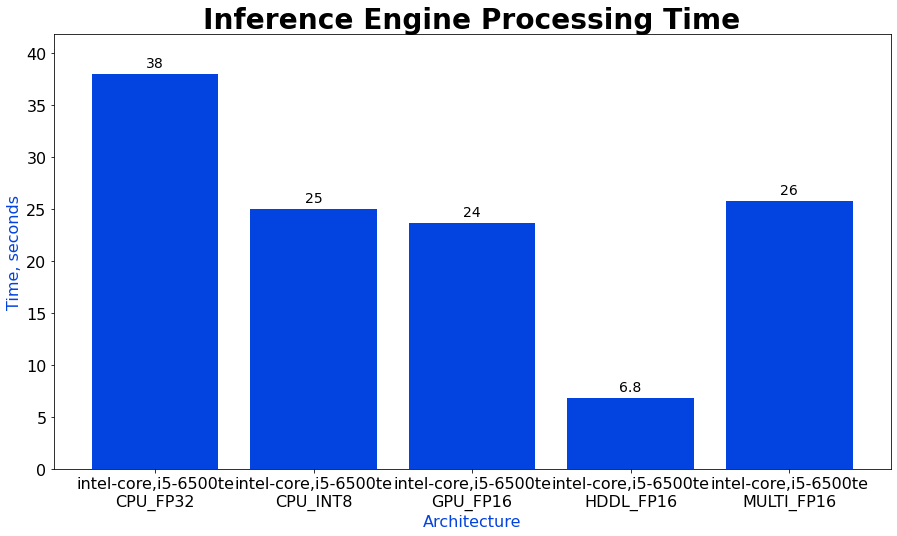

HTML(value="Benchmark results published by Intel or appearing on the Intel® DevCloud for the Edge website are …

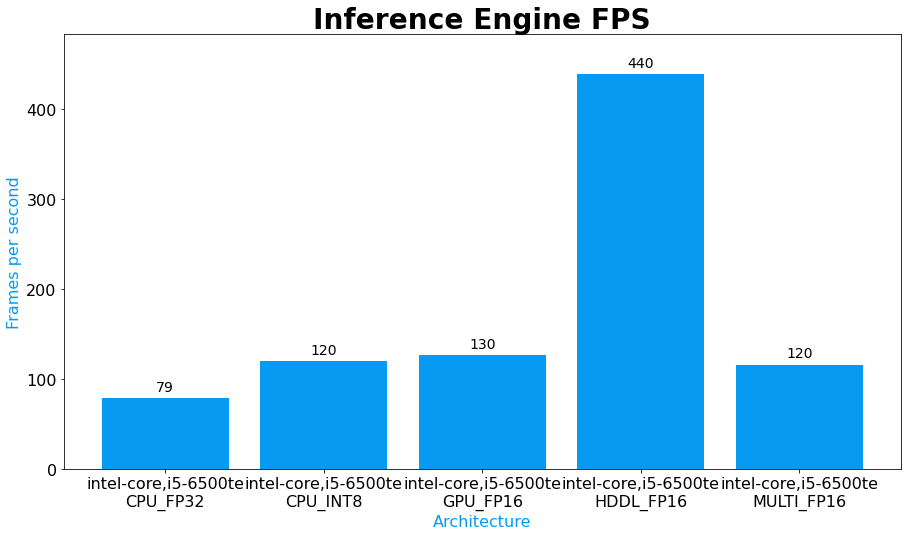

HTML(value="Benchmark results published by Intel or appearing on the Intel® DevCloud for the Edge website are …

In [39]:
# Create table of <architecture>, <title> for plotting
arch_list = [('core_cpu_fp32', 'intel-core,i5-6500te\nCPU_FP32'),
             ('core_cpu_int8', 'intel-core,i5-6500te\nCPU_INT8'),
             ('core_gpu_fp16', 'intel-core,i5-6500te\nGPU_FP16'),
             ('core_hddl_fp16', 'intel-core,i5-6500te\nHDDL_FP16'),
             ('core_multi_fp16', 'intel-core,i5-6500te\nMULTI_FP16')]
          
# For each archtecture in table, create path to stats file or placeholder 
stats_list = []
for arch, a_name in arch_list:
    # if job_id_<architecture> exists, the job was run and has a stats file
    if 'job_id_'+arch in vars():
        stats_list.append((f'results/{arch}/stats_{vars()["job_id_"+arch][0]}.txt', a_name))
    else:
        stats_list.append(('placeholder'+arch, a_name))

# Plot the execution time from the stats files
summaryPlot(stats_list, 'Architecture', 'Time, seconds', 'Inference Engine Processing Time', 'time')
# Plot the frames per second from the stats files
summaryPlot(stats_list, 'Architecture', 'Frames per second', 'Inference Engine FPS', 'fps')

In [20]:
print(stats_list)

[('results/core_cpu_fp32/stats_466299.v-qsvr-1.devcloud-edge.txt', 'intel-core,i5-6500te\nCPU_FP32'), ('placeholdercore_cpu_INT8', 'intel-core,i5-6500te\nCPU_INT8')]


## Telemetry Dashboard
Once your submitted jobs are completed, run the cells below to view telemetry dashboards containing performance metrics for your model and target architecture.


In [40]:
link_t = "<a target='_blank' href='{href}'> Click here to view telemetry dashboard of the last job ran on Intel® Core™ i5-6500TE</a>"

result_file = "https://devcloud.intel.com/edge/metrics/d/" + job_id_core_cpu_fp32[0].split('.')[0]

html = HTML(link_t.format(href=result_file))

display(html)

## Next steps
- [More Jupyter* Notebook Samples](https://devcloud.intel.com/edge/advanced/sample_applications/) - additional sample applications 
- [Jupyter* Notebook Tutorials](https://devcloud.intel.com/edge/get_started/tutorials) - sample application Jupyter* Notebook tutorials
- [Intel® Distribution of OpenVINO™ toolkit Main Page](https://software.intel.com/openvino-toolkit) - learn more about the tools and use of the Intel® Distribution of OpenVINO™ toolkit for implementing inference on the edge


## About this notebook

For technical support, please see the [Intel® DevCloud Forums](https://software.intel.com/en-us/forums/intel-devcloud-for-edge)

<p style=background-color:#0071C5;color:white;padding:0.5em;display:table-cell;width:100pc;vertical-align:middle>
<img style=float:right src="https://devcloud.intel.com/edge/static/images/svg/IDZ_logo.svg" alt="Intel DevCloud logo" width="150px"/>
<a style=color:white>Intel® DevCloud for the Edge</a><br>   
<a style=color:white href="#top">Top of Page</a> | 
<a style=color:white href="https://devcloud.intel.com/edge/static/docs/terms/Intel-DevCloud-for-the-Edge-Usage-Agreement.pdf">Usage Agreement (Intel)</a> | 
<a style=color:white href="https://devcloud.intel.com/edge/static/docs/terms/Colfax_Cloud_Service_Terms_v1.3.pdf">Service Terms (Colfax)</a>
</p>